**Time Series Forecasting with LSTM and Bidirectional LSTM**

This code performs *time series forecasting* using an LSTM and a Bidirectional LSTM neural network. The dataset used for forecasting contains information about unit sales, item numbers, and store numbers. The goal is to predict future unit sales for a given item in a given store. The code is organized as follows:

* Import necessary libraries: Import required libraries for data processing, model building, and evaluation.
* Define functions: Define functions for time-delay embedding, data transformation, and data manipulation.
* Load and preprocess data: Load the dataset and preprocess it by adding a unique identifier, removing unnecessary columns, and filtering the data for 5 random unique identifiers.
* Prepare train and test sets: Split the data into train and test sets for each group, scale the data using MinMaxScaler, create observations using the sliding window method, and transform the data into a 3D format suitable for deep learning.
* Define and train the neural network: Define the LSTM and Bidirectional LSTM models, split the training data into development and validation sets, and train the neural network using early stopping.
* Make predictions and evaluate the model: Prepare the test set for the model, make predictions, inverse transform the predicted and actual values to their original scale, and compare the results. Plot the training data, test data, and predicted values for each unique identifier in the test set.
* Calculate evaluation metrics: Calculate the mean absolute error (MAE), root mean squared error (RMSE), and mean absolute scaled error (MASE) for each unique identifier in the test set, and store the results in a DataFrame.

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
import re
import numpy as np
import pandas as pd
import random


def time_delay_embedding(series: pd.Series,
                         n_lags: int,
                         horizon: int,
                         return_Xy: bool = False):
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    df_list = [series.shift(i) for i in n_lags_iter]
    df = pd.concat(df_list, axis=1).dropna()
    df.columns = [f'{name}(t-{j - 1})'
                  if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                  for j in n_lags_iter]

    df.columns = [re.sub('t-0', 't', x) for x in df.columns]

    if not return_Xy:
        return df

    is_future = df.columns.str.contains('\+')

    X = df.iloc[:, ~is_future]
    Y = df.iloc[:, is_future]
    if Y.shape[1] == 1:
        Y = Y.iloc[:, 0]

    return X, Y

def from_matrix_to_3d(df: pd.DataFrame) -> np.ndarray:
    cols = df.columns

    var_names = np.unique([re.sub(r'\([^)]*\)', '', c) for c in cols]).tolist()

    arr_by_var = [df.loc[:, cols.str.contains(v)].values for v in var_names]
    
    # Get the maximum number of columns among all arrays
    max_cols = max([x.shape[1] for x in arr_by_var])
    
    # Pad the arrays with zeros to have the same number of columns
    arr_by_var = [np.pad(x, ((0, 0), (0, max_cols - x.shape[1])), mode='constant') for x in arr_by_var]
    
    arr_by_var = [x.reshape(x.shape[0], max_cols, 1) for x in arr_by_var]

    ts_arr = np.concatenate(arr_by_var, axis=2)

    return ts_arr


def from_3d_to_matrix(arr: np.ndarray, col_names: pd.Index):
    if arr.shape[2] > 1:
        arr_split = np.dsplit(arr, arr.shape[2])
    else:
        arr_split = [arr]

    arr_reshaped = [x.reshape(x.shape[0], x.shape[1]) for x in arr_split]

    df = pd.concat([pd.DataFrame(x) for x in arr_reshaped], axis=1)

    # Find unique variable names without the parentheses and their content
    unique_var_names = np.unique([re.sub(r'\([^)]*\)', '', c) for c in col_names]).tolist()

    # Create a list of column name lists for each variable
    cols_by_var = [col_names[col_names.str.contains(v)].tolist() for v in unique_var_names]

    # Assign the appropriate column names to each DataFrame
    df_list = [pd.DataFrame(x, columns=cols) for x, cols in zip(arr_reshaped, cols_by_var)]

    # Concatenate the DataFrames along the columns axis
    df = pd.concat(df_list, axis=1)

    return df


# Define the path to 'total.csv'
total_csv_path = '/kaggle/input/shopping/shop_cat.csv'

# Load 'total.csv' and set index to 'date'
data = pd.read_csv(total_csv_path, parse_dates=['date'], index_col='date')
data = data[data['store'] == 548]

# Add 'unique_id' column
data['unique_id'] = data['item_nbr'].astype(str) + '_' + data['store'].astype(str)

# Drop 'item_nbr' and 'store' columns
data.drop(['item_nbr', 'store'], axis=1, inplace=True)


# Assuming the data is already loaded into the DataFrame 'data'
data['category'] = data['category'].fillna('undefined')

# Check if there are any NaN values left in the 'category' column
nan_category_count = data['category'].isna().sum()

print("Number of rows with NaN values in the 'category' column after replacement:")
print(nan_category_count)

#################################
# Select 10 random unique_ids and filter the data
random_unique_ids = random.sample(list(data['unique_id'].unique()), 2)
data = data[data['unique_id'].isin(random_unique_ids)]
#################################

# One-hot encoding for the 'category' column if there are more categories
data = pd.get_dummies(data, columns=['category'])

# Remove 'unique_id' from the list of features
features = data.columns.tolist()
features.remove('unit_sales')
features.remove('unique_id')
#features.remove('index')

data

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of rows with NaN values in the 'category' column after replacement:
0


,unit_sales,bogo,circular_discount,circular,circedlp,coupon,discount_value,discount,fp_discount,front_page,fpedlp,gas,nopromo,unique_id,category_MEAT,category_PRODUCE
date,,,,,,,,,,,,,,,,
2021-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,150286_548,1,0
2021-01-24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,150286_548,1,0
2021-01-25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,150286_548,1,0
2021-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,150286_548,1,0
2021-01-27,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,150286_548,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-18,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,279214_548,0,1
2023-02-19,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,279214_548,0,1
2023-02-20,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,279214_548,0,1


In [3]:
# Group the data by 'unique_id'
grouped_data = data.groupby('unique_id')

# Define the number of features, lags, and horizon for time_delay_embedding
N_FEATURES = len(features) + 1  # Include 'unit_sales' as a feature
N_LAGS = 14
HORIZON = 1

# Initialize empty lists for storing train and test sets
train_list = []
test_list = []
scalers = {}

# Split the data into train and test sets for each group
for unique_id, group in grouped_data:
    train_group, test_group = train_test_split(group, test_size=0.2, shuffle=False)

    # Scaling 'unit_sales' using MinMaxScaler
    scaler = MinMaxScaler()
    train_group['unit_sales'] = scaler.fit_transform(train_group[['unit_sales']])
    test_group['unit_sales'] = scaler.transform(test_group[['unit_sales']])

    # Store the scaler for each unique_id
    scalers[unique_id] = scaler

    # Create observations using the sliding window method
    train_group_df = time_delay_embedding(train_group['unit_sales'], n_lags=N_LAGS, horizon=HORIZON)
    test_group_df = time_delay_embedding(test_group['unit_sales'], n_lags=N_LAGS, horizon=HORIZON)

    # Add the rest of the columns as explanatory variables and 'unique_id'
    train_group_df[features + ['unique_id']] = train_group[features + ['unique_id']]
    test_group_df[features + ['unique_id']] = test_group[features + ['unique_id']]

    train_list.append(train_group_df)
    test_list.append(test_group_df)


# Combine the train and test sets for all groups
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

# Define target (Y) and explanatory variables (X)
predictor_variables = train_df.columns.str.contains('\(t\-|\(t\)')
target_variables = train_df.columns.str.contains('\(t\+')

# The features should also be considered as predictor variables
predictor_variables |= train_df.columns.isin(features)

X_tr = train_df.iloc[:, predictor_variables]
Y_tr = train_df.iloc[:, target_variables]

# Transform the data from matrix into a 3-d format for deep learning
X_tr_3d = from_matrix_to_3d(X_tr)
Y_tr_3d = from_matrix_to_3d(Y_tr)

# Modeling

* The code uses an LSTM model with 128 neurons in the first layer and 64 neurons in the second layer, with dropout layers to reduce overfitting. The Bidirectional LSTM model has 256 neurons in the first layer and 128 neurons in the second layer. The models are trained using the Adam optimizer and mean squared error loss function.

In [4]:
# MODEL 1
# Define the neural network
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(N_LAGS, N_FEATURES)))
model.add(Dropout(.2))
model.add(RepeatVector(HORIZON))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(.2))
#model.add(TimeDistributed(Dense(N_FEATURES)))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

'''
#MODEL 2
# Define the neural network
model = Sequential()
model.add(Bidirectional(LSTM(256, activation='relu', input_shape=(N_LAGS, N_FEATURES))))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(RepeatVector(HORIZON))
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(N_FEATURES)))
model.compile(optimizer='adam', loss='mse')
'''

# Split training into a development and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(X_tr_3d, Y_tr_3d, test_size=.2, shuffle=False)

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the neural network
model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=20, callbacks=[early_stopping])

# Prepare the test set for the model
X_te = test_df.iloc[:, predictor_variables]
Y_te = test_df.iloc[:, target_variables]

# Transform the test set into the 3D format
X_te_3d = from_matrix_to_3d(X_te)

# Make predictions using the model
Y_pred = model.predict(X_te_3d)

# Reshape the predictions to the original 2D format using the from_3d_to_matrix function
Y_pred_2d = from_3d_to_matrix(Y_pred, Y_te.columns)

# Inverse transform the predicted and actual values to their original scale
Y_pred_2d_inv = np.zeros_like(Y_pred_2d)
Y_te_2d = Y_te.values
Y_te_2d_inv = np.zeros_like(Y_te_2d)

for unique_id in random_unique_ids:
    unique_id_mask = test_df['unique_id'] == unique_id
    Y_pred_2d_inv[unique_id_mask.values] = scalers[unique_id].inverse_transform(Y_pred_2d[unique_id_mask.values])
    Y_te_2d_inv[unique_id_mask.values] = scalers[unique_id].inverse_transform(Y_te_2d[unique_id_mask.values])



# Extract only the unit_sales columns from the predicted values
unit_sales_columns = Y_te.columns[Y_te.columns.str.contains('unit_sales')]
Y_pred_unit_sales = Y_pred_2d_inv[:, :len(unit_sales_columns)]


# Clip the negative predictions to zero
Y_pred_unit_sales = np.clip(Y_pred_unit_sales, 0, None)

# Create a dataframe with the predicted values
Y_pred_df = pd.DataFrame(Y_pred_unit_sales, columns=unit_sales_columns)
Y_pred_df.index = test_df.index[-Y_pred_df.shape[0]:]


# Create new column names for actual values
actual_columns = [f'actual_t+{i+1}' for i in range(HORIZON)]

# Create a new DataFrame with the predicted and actual values and 'unique_id'
results_df = pd.DataFrame(Y_te_2d_inv, columns=actual_columns, index=test_df.index[-Y_pred_df.shape[0]:])
results_df['unique_id'] = test_df['unique_id']
Y_pred_df = Y_pred_df[unit_sales_columns]

# Add predicted columns to the results_df
for i in range(HORIZON):
    results_df[f'predicted_t+{i+1}'] = Y_pred_df.iloc[:, i]
    

# Reorder the columns to make 'unique_id' the first column
column_order = ['unique_id'] + actual_columns + [f'predicted_t+{i+1}' for i in range(HORIZON)]
results_df = results_df[column_order]

# Print the comparison table
results_df

Epoch 1/20
30/30 [==============================] - 5s 38ms/step - loss: 0.0235 - val_loss: 0.0077
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0185 - val_loss: 0.0084
Epoch 3/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0173 - val_loss: 0.0073
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0168 - val_loss: 0.0074
Epoch 5/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0166 - val_loss: 0.0074
Epoch 6/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0166 - val_loss: 0.0073
Epoch 7/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0170 - val_loss: 0.0073
Epoch 8/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0166 - val_loss: 0.0074
Epoch 9/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0166 - val_loss: 0.0073
Epoch 10/20
9/9 [==============================] - 0s 9ms/step


,unique_id,actual_t+1,predicted_t+1
date,,,
2022-10-07,150286_548,0.0,0.679236
2022-10-08,150286_548,0.0,0.679067
2022-10-09,150286_548,1.0,0.644397
2022-10-10,150286_548,1.0,0.657606
2022-10-11,150286_548,5.0,0.680170
...,...,...,...
2023-02-18,279214_548,8.0,1.270927
2023-02-19,279214_548,1.0,1.449025
2023-02-20,279214_548,2.0,1.426292


## Plot

In [5]:
import matplotlib.pyplot as plt

# Loop through each unique_id in the test set
for unique_id in random_unique_ids:
    # Filter the data for the current unique_id
    train_filtered = train_df[train_df['unique_id'] == unique_id]
    test_filtered = test_df[test_df['unique_id'] == unique_id]
    results_filtered = results_df[results_df['unique_id'] == unique_id]

    # Extract the unit sales values for the current unique_id
    Y_train_filtered = train_filtered.iloc[:, target_variables].values
    Y_te_filtered = test_filtered.iloc[:, target_variables].values

    # Inverse transform the unit sales values
    Y_train_inv = scalers[unique_id].inverse_transform(Y_train_filtered)
    Y_te_inv = scalers[unique_id].inverse_transform(Y_te_filtered)

    # Get the inverse-transformed predicted values directly from the 'results_filtered' DataFrame
    Y_pred_inv = results_filtered.iloc[:, len(actual_columns):].values
    
    '''
    # Plot the training data, test data, and predicted values for the current unique_id
    plt.figure(figsize=(15, 5))
    plt.plot(train_filtered.index[-len(Y_train_inv):], Y_train_inv[:, 0], label='Training Data')
    plt.plot(test_filtered.index[:len(Y_te_inv)], Y_te_inv[:, 0], label='Test Data')
    plt.plot(results_filtered.index[:len(Y_pred_inv)], Y_pred_inv[:, 1], label='Predicted Values')  # Use the second column for predicted values
    plt.title(f"Time Series {unique_id}")
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.show()
    '''

# Evaluation Metrics

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the MASE
def mean_absolute_scaled_error(mae, y_train):
    mae_naive = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    mase = mae / mae_naive
    return mase

# Create an empty DataFrame with the desired columns
evaluation_metrics_lstm = pd.DataFrame(columns=['unique_id', 'MAE', 'RMSE', 'MASE'])

# Loop through each unique_id in the test set
for unique_id in random_unique_ids:
    # Filter the data for the current unique_id
    train_filtered = train_df[train_df['unique_id'] == unique_id]
    test_filtered = test_df[test_df['unique_id'] == unique_id]
    results_filtered = results_df[results_df['unique_id'] == unique_id]

    # Extract the unit sales values for the current unique_id
    Y_train_filtered = train_filtered.iloc[:, target_variables].values
    Y_te_filtered = test_filtered.iloc[:, target_variables].values

    # Inverse transform the unit sales values
    Y_train_inv = scalers[unique_id].inverse_transform(Y_train_filtered)
    Y_te_inv = scalers[unique_id].inverse_transform(Y_te_filtered)

    # Get the inverse-transformed predicted values directly from the 'results_filtered' DataFrame
    Y_pred_inv = results_filtered.iloc[:, len(actual_columns):].values

    # Calculate the MAE
    mae = mean_absolute_error(Y_te_inv[:, 0], Y_pred_inv[:, 1])

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_error(Y_te_inv[:, 0], Y_pred_inv[:, 1]))

    # Calculate the MASE
    mase = mean_absolute_scaled_error(mae, Y_train_inv[:, 0])
   
    # Append a new row to the DataFrame with the calculated metrics
    evaluation_metrics_lstm = evaluation_metrics_lstm.append({'unique_id': unique_id,
                                                              'MAE': mae,
                                                              'RMSE': rmse,
                                                              'MASE': mase},
                                                             ignore_index=True)

    
    

evaluation_metrics_lstm.to_csv('metrics_lstm.csv', index=False)

# Print the evaluation_metrics_lstm DataFrame
evaluation_metrics_lstm

/tmp/ipykernel_19/2435349396.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_lstm = evaluation_metrics_lstm.append({'unique_id': unique_id,
/tmp/ipykernel_19/2435349396.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_lstm = evaluation_metrics_lstm.append({'unique_id': unique_id,


,unique_id,MAE,RMSE,MASE
0,150286_548,0.784445,0.970120,0.731409
1,279214_548,0.992493,1.247558,0.877122


In [7]:
import plotly.graph_objs as go

# Create a box plot for MAE
trace1 = go.Box(
    y=evaluation_metrics_lstm['MAE'],
    name="MAE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for RMSE
trace2 = go.Box(
    y=evaluation_metrics_lstm['RMSE'],
    name="RMSE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a box plot for MASE
trace3 = go.Box(
    y=evaluation_metrics_lstm['MASE'],
    name="MASE",
    boxpoints='outliers',
    jitter=0.3,
    pointpos=0,
    boxmean=True
)

# Create a layout for the box plots
layout = go.Layout(
    title="Evaluation Metrics Box Plots",
    yaxis=dict(title="Value"),
    boxmode='group'
)

# Combine the traces and layout into a single figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Plot the figure
fig.show()


# Interpretability 

In [8]:
import shap
import matplotlib

# Wrap the Keras model with a function that takes a 2D input (SHAP uses 2D input)
def lstm_model_predict(input_data):
    input_3d = from_matrix_to_3d(input_data)
    return model.predict(input_3d)

def lstm_model_predict_wrapper(input_data):
    # Convert the NumPy array to a DataFrame
    input_data_df = pd.DataFrame(input_data, columns=X_tr.columns)
    
    # Call the lstm_model_predict function with the DataFrame input
    predictions = lstm_model_predict(input_data_df)
    
    # Reshape the predictions to 2D
    predictions_2d = predictions.reshape(predictions.shape[0], predictions.shape[2])
    
    print("Input data shape:", input_data.shape)
    print("Input data DataFrame shape:", input_data_df.shape)
    print("Predictions shape:", predictions.shape)
    print("Reshaped predictions shape:", predictions_2d.shape)
    
    return predictions_2d

# print the JS visualization code to the notebook
shap.initjs()

## Feature Importance

4/4 [==============================] - 0s 7ms/step
Input data shape: (100, 28)
Input data DataFrame shape: (100, 28)
Predictions shape: (100, 1, 1)
Reshaped predictions shape: (100, 1)


  0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step
Input data shape: (1, 28)
Input data DataFrame shape: (1, 28)
Predictions shape: (1, 1, 1)
Reshaped predictions shape: (1, 1)
6488/6488 [==============================] - 53s 8ms/step
Input data shape: (207600, 28)
Input data DataFrame shape: (207600, 28)
Predictions shape: (207600, 1, 1)
Reshaped predictions shape: (207600, 1)
1/1 [==============================] - 0s 34ms/step
Input data shape: (1, 28)
Input data DataFrame shape: (1, 28)
Predictions shape: (1, 1, 1)
Reshaped predictions shape: (1, 1)
6488/6488 [==============================] - 54s 8ms/step
Input data shape: (207600, 28)
Input data DataFrame shape: (207600, 28)
Predictions shape: (207600, 1, 1)
Reshaped predictions shape: (207600, 1)
1/1 [==============================] - 0s 30ms/step
Input data shape: (1, 28)
Input data DataFrame shape: (1, 28)
Predictions shape: (1, 1, 1)
Reshaped predictions shape: (1, 1)
6488/6488 [==============================] - 52s 8ms/step


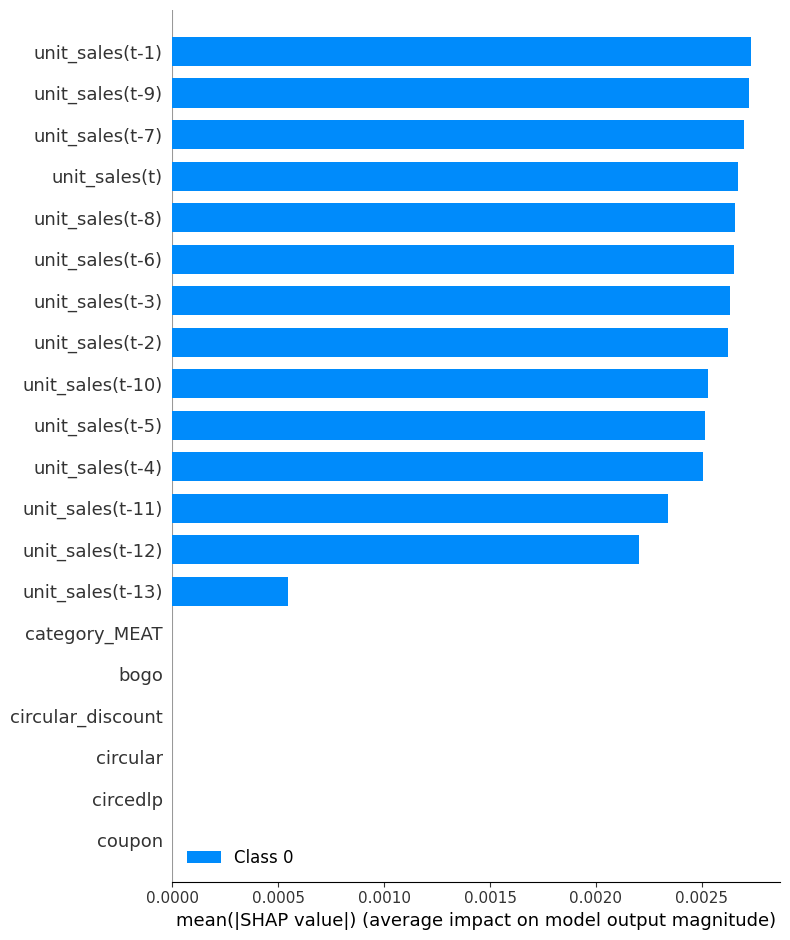

In [9]:
# Create a SHAP explainer
explainer = shap.KernelExplainer(lstm_model_predict_wrapper, X_tr.iloc[:100])

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_te.iloc[:20])

# Plot the SHAP values
shap.summary_plot(shap_values, X_te.iloc[:20])

## Explain a single prediction

Each feature value is a force that either increases or decreases the prediction. The prediction starts from the baseline. The baseline for Shapley values is the average of all predictions. In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. These forces balance each other out at the actual prediction of the data instance.

In [10]:
# Create a SHAP explainer
explainer = shap.KernelExplainer(lstm_model_predict_wrapper, X_tr.iloc[:200])

# Choose an appropriate index within the range of your test set
test_instance_index = 70  # Or any other valid index between 0 and 277
shap_values = explainer.shap_values(X_te.iloc[test_instance_index, :], nsamples=500)

# Select the desired output for the force plot (e.g., the first output)
output_index = 0
shap_values_output = shap_values[output_index]

# Create the force plot for the desired output
shap.force_plot(explainer.expected_value[output_index], shap_values_output, X_te.iloc[test_instance_index, :])

7/7 [==============================] - 0s 7ms/step
Input data shape: (200, 28)
Input data DataFrame shape: (200, 28)
Predictions shape: (200, 1, 1)
Reshaped predictions shape: (200, 1)
1/1 [==============================] - 0s 28ms/step
Input data shape: (1, 28)
Input data DataFrame shape: (1, 28)
Predictions shape: (1, 1, 1)
Reshaped predictions shape: (1, 1)
3125/3125 [==============================] - 26s 8ms/step
Input data shape: (100000, 28)
Input data DataFrame shape: (100000, 28)
Predictions shape: (100000, 1, 1)
Reshaped predictions shape: (100000, 1)


##  Explain many predictions

In [11]:
shap_values50 = explainer.shap_values(X_te.iloc[0:50,:], nsamples=500)

# Choose the desired output index
output_index = 0

# Create the force plot for the chosen output
shap.force_plot(explainer.expected_value[output_index], shap_values50[output_index], X_te.iloc[0:50,:])

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step
Input data shape: (1, 28)
Input data DataFrame shape: (1, 28)
Predictions shape: (1, 1, 1)
Reshaped predictions shape: (1, 1)
3125/3125 [==============================] - 26s 8ms/step
Input data shape: (100000, 28)
Input data DataFrame shape: (100000, 28)
Predictions shape: (100000, 1, 1)
Reshaped predictions shape: (100000, 1)
1/1 [==============================] - 0s 28ms/step
Input data shape: (1, 28)
Input data DataFrame shape: (1, 28)
Predictions shape: (1, 1, 1)
Reshaped predictions shape: (1, 1)
3125/3125 [==============================] - 26s 8ms/step
Input data shape: (100000, 28)
Input data DataFrame shape: (100000, 28)
Predictions shape: (100000, 1, 1)
Reshaped predictions shape: (100000, 1)
1/1 [==============================] - 0s 27ms/step
Input data shape: (1, 28)
Input data DataFrame shape: (1, 28)
Predictions shape: (1, 1, 1)
Reshaped predictions shape: (1, 1)
3125/3125 [==============================] - 26s 8ms/step


##  Summary Plot

The summary plot combines feature importance with feature effects. Each point on the summary plot is a Shapley value for a feature and an instance. The position on the y-axis is determined by the feature and on the x-axis by the Shapley value. The color represents the value of the feature from low to high. Overlapping points are jittered in y-axis direction, so we get a sense of the distribution of the Shapley values per feature. The features are ordered according to their importance.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


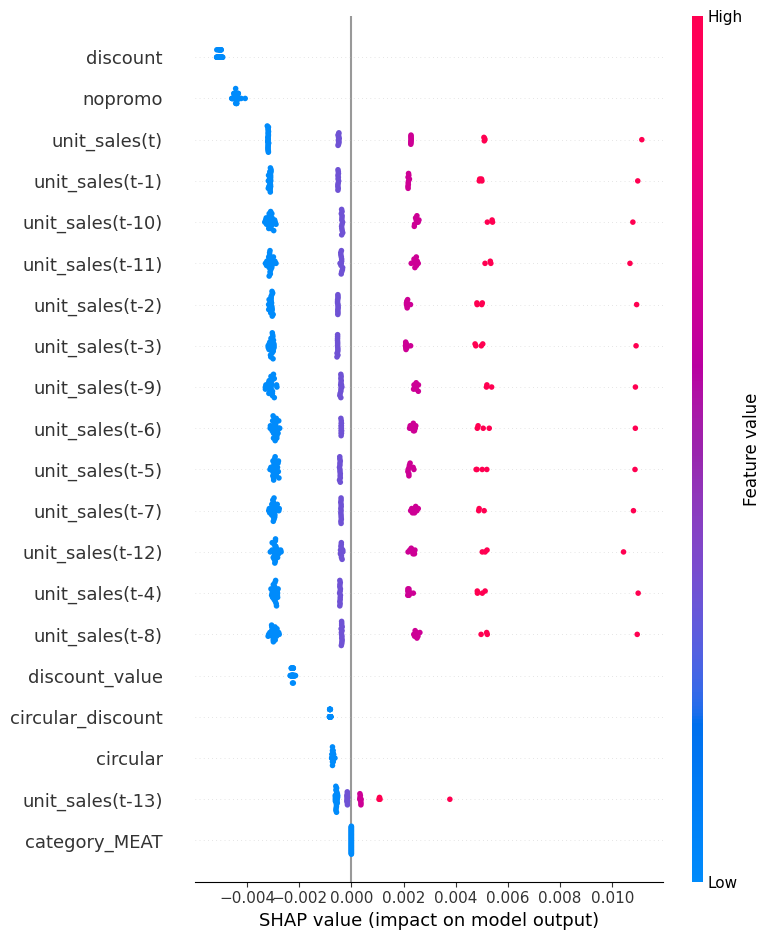

In [12]:
# Choose the desired output index
output_index = 0

# Create the summary plot for the chosen output
shap.summary_plot(shap_values=shap_values50[output_index], features=X_te.iloc[0:50, :])